<h1>Numeric  integration  with Julia:</h1>

<p>To get started, we load the <code>MTH229</code> package:</p>

In [1]:
using MTH229
using SimplePlots

<h3>Quick background</h3>

<p>Read more about this material here: <a href="http://mth229.github.io/integration.html">integration</a>.</p>

<p>For the impatient, in many cases the task of evaluating a definite integral is made easy by the fundamental theorem of calculus. This states that a continuous function $f$ with (any) antiderivative, $F$,  that</p>


$$
\int_a^b f(x) dx = F(b) - F(a).
$$


<p>That is, the definite integral is found by evaluating a related function at the endpoints, $a$ and $b$.</p>

<p>The <code>SymPy</code> package can compute many antiderivatives using a version of the <a href="http://en.wikipedia.org/wiki/Risch\_algorithm">Risch algorithm</a> that works for <a href="http://en.wikipedia.org/wiki/Elementary\_function">elementary functions</a>. <code>SymPy</code>'s <code>integrate</code> function can be used to find an indefinite integral:</p>

In [1]:
f(x) = x^2
integrate(f)

<p>Or a definite integral by passing in values <code>a</code> and <code>b</code>:</p>

In [1]:
integrate(f, 0, 1)		# returns a "symbolic" number

<p>However, this only works <em>if</em> there is a known antiderivative $F(x)$–-which is not always the case. If not, what to do?</p>

<p>In this case, we can appeal to the <em>definition</em> of the definite integral. For continuous non-negative $f(x)$, the definite integral is the area under the graph of $f$ over the interval $[a,b]$. For possibly negative functions, the indefinite integral is found by the <em>signed</em> area under $f$.  This area can be directly <em>approximated</em> using Riemann sums, or some other approximation scheme.</p>

<p>The Riemann approximation for a definite integral uses approximating rectangles. The following pattern will compute a Riemann sum with equal-sized partitions using right-hand endpoints:</p>

In [1]:
f(x) = x^2
a, b, n = 0, 1, 5		# 5 partitions of [0,1] requested
delta = (b - a)/n		# size of partition
xs = a .+ (1:n) * delta
sum(f.(xs) * delta)		# a new function `sum` to add up values in a container

0.44000000000000006

<p>That value isn't very close to $1/3$. But we only took $n=5$ rectangles $-$ clearly there will be some error, as we can see in this figure, where each approximating rectangle overestimates the area under the curve:</p>

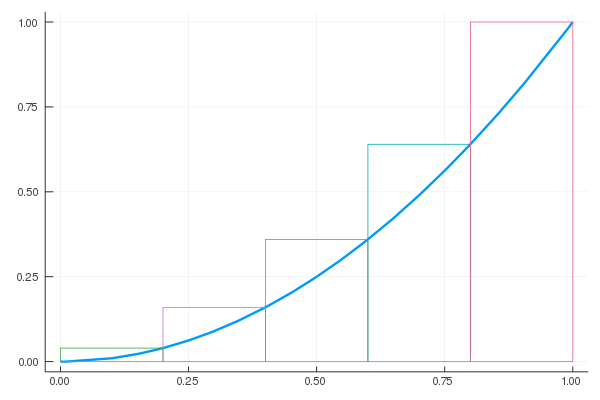

<p>Bigger $n$s mean better approximations. This figure overlays the picture with $n=10$ and emphasizes the excess area that is lost:</p>

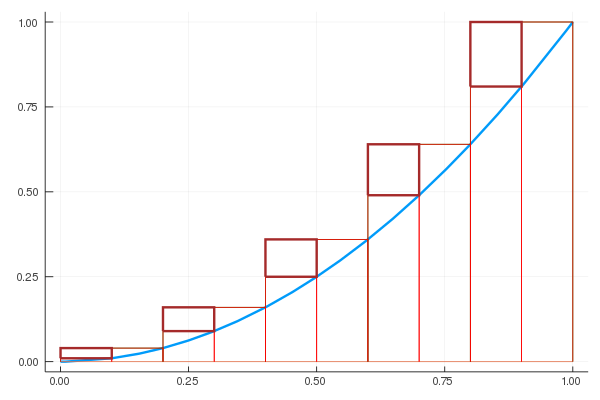

<p>With large <code>n</code> the figures become too crowded to illustrate, but we can easily use a large value of <code>n</code> in our computations. With $n=50,000$ we have the first $4$ decimal points are accurate:</p>

In [1]:
f(x) = x^2
a, b, n = 0, 1, 50_000		# 50,000 partitions of [0,1] requested
delta = (b - a)/n
xs = a .+ (1:n) * delta
sum(f.(xs) * delta)

0.33334333340000005

<p>Note that only the first two lines of the calculation needed changing to adjust to a new problem. As the pattern is similar, it is fairly easy to wrap the computations in a function for convenience. The following one is in the <code>MTH229</code> package and works for some other methods beside the default right-Riemann sum:</p>

In [1]:
function riemann(f::Function, a::Real, b::Real, n::Int; method="right")
  if method == "right"
     meth = (f,l,r) -> f(r) * (r-l)
  elseif method == "left"
     meth = (f,l,r) -> f(l) * (r-l)
  elseif method == "trapezoid"
     meth = (f,l,r) -> (1/2) * (f(l) + f(r)) * (r-l)
  elseif method == "simpsons"
     meth = (f,l,r) -> (1/6) * (f(l) + 4*(f((l+r)/2)) + f(r)) * (r-l)
  end

  xs = a .+ (0:n) * (b-a)/n
  as = [meth(f, l, r) for (l,r) in zip(xs[1:end-1], xs[2:end])]
  sum(as)
end

<hr />

<p>The Riemann sum is  slow to converge here. There are faster algorithms both mathematically and computationally. We will briefly discuss two: the <a href="https://en.wikipedia.org/wiki/Trapezoidal_rule">trapezoid</a> rule, which replaces rectangles with trapezoids; and <a href="https://en.wikipedia.org/wiki/Simpson&#37;27s_rule">Simpson's</a>rule which is a quadratic approximation. Each is invoked by passing a value to the <code>method</code> argument:</p>

In [1]:
f(x) = x^2
riemann(f, 0, 1, 1000, method="trapezoid")

0.33333350000000006

<p>And for Simpson's method:</p>

In [1]:
riemann(f, 0, 1, 1000, method="simpsons")

0.33333333333333326

<hr />

<p>For real-world use, <code>Julia</code> has a <code>QuadGK</code> package and its function <code>quadgk</code>, By using a different approach altogether, this function is much more efficient and estimates the potential error in the approximation.  It is used quite easily–-no $n$ is needed, as the algorithm is adaptive:</p>

In [1]:
f(x) = x^2
answer, err = quadgk(f, 0, 1)

(0.3333333333333333, 5.551115123125783e-17)

<p>The <code>quadgk</code> function returns two values, an answer and an estimated maximum possible error.  The answer is the first number, clearly it is $1/3$, and the estimated maximum error is the second. In this case it is small ($10^{-17}$) $-$ basically 0.</p>

<hr />

<p>In summary we consider here these functions to find definite integrals:</p>

<ul>
<li><p><code>integrate</code>–-symbolically find a definite integral using the fundamental theorem of calculus, if possible.</p>
</li>
<li><p><code>riemann</code>–-approximate a definite integral using either Riemann sums or a related method.</p>
</li>
<li><p><code>quadgk</code>–-use Gauss quadrature approach to efficiently find approximations to definite integrals.</p>
</li>
</ul>

<h2>Different interpretations of other integrals</h2>

<p>The integral can represent other quantities besides the area under a curve. We give two examples: arc-length and certain volumes of revolution.</p>

<p>A formula to compute the length of a the graph of the function $f(x)$   from $a$ to $b$ is given by the formula:</p>


$$
\int_a^b \sqrt{1 + f'(x)^2} dx
$$


<p>That is, a function <em>related</em> to $f$ is integrated and this has a different interpretation than the area under $f$.</p>

<p>For example, the arc-length of the square root function between $[0, 4]$ is given by:</p>

In [1]:
f(x) = sqrt(x)
l(x) = sqrt(1 + f'(x)^2)
answer, err = quadgk(l, 0, 4)

(4.6467837188706085, 6.719390994754717e-8)

<h2>Application: Volume of glasses.</h2>

<p>We discuss an application of the integral to finding volumes–-not areas.</p>

<p>A <em>solid of revolution</em> is a figure with rotational symmetry around some axis, such as a soda can, a snow cone, a red solo cup, and other common objects. A formula for the volume of an object with rotational symmetry can be written in terms of an integral based on a function, $r(h)$, which specifies the radius for various values of $h$.</p>

<blockquote>
<p>If the radius as a function of height is given by $r(h)$, the the volume is $\int_a^b \pi r(h)^2 dh$.</p>
</blockquote>

<p>So for example, a baseball has a overall diameter of $2\cdot 37$mm, but if we place the center at the origin, its rotational radius is given by $r(h) = (37^2 - h^2)^{1/2}$ for $-37 \leq h \leq 37$. The volume in mm$^3$ is given by:</p>

In [1]:
r(h) = (37^2 - h^2)^(1/2)
v(h) = pi * r(h)^2
answer, err = quadgk(v, -37, 37)

(212174.79024304505, 2.9103830456733704e-11)

<p>The volume in cubic inches, then is:</p>

In [1]:
answer / (2.54 * 10)^3

12.947700103145083

<hr />